In [1]:
from synthetic.predictor import predict_trajectory
import numpy as np
import matplotlib.pyplot as plt
import lfg
from draw_util import draw_util
from pycamera import CameraParam
import csv
from omegaconf import OmegaConf
from pathlib import Path
from tqdm import tqdm
%matplotlib widget

CONFIG = OmegaConf.load("config.yaml")
# toggle cases
TEST_SINGLE_CASE = False
GENERATE_SYNTHETIC_DATA = True 
VIEW_SYNTHETIC_DATA = True
GENERATE_CAMERA_DATA_WITH_NOISE = True
VIEW_SYNTHETIC_CAMERA_DATA = True

In [3]:
# load camera parameters
camera_param_dict = {camera_id: CameraParam.from_yaml(Path(CONFIG.camera.folder) / f'{camera_id}_calibration.yaml') for camera_id in CONFIG.camera.cam_ids}
camera_ids = CONFIG.camera.cam_ids

def test_single_case():
    
    p0 = np.array([0.5, -2.4, 0.2])
    v0 = np.array([0.0, 5.0, 1.5])
    w0 = np.array([0.0, 30.0, 0.0]) * np.pi * 2
    tspan = np.linspace(0, 1.0, 100)
    traj = predict_trajectory(p0, v0, w0, tspan)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(traj[:,0],traj[:,1],traj[:,2],s=3, label='sim')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.legend()
    for cm in camera_param_dict.values():
        cm.draw(ax,scale=0.20)
    draw_util.set_axes_equal(ax)
    draw_util.set_axes_pane_white(ax)
    draw_util.draw_pinpong_table_outline(ax)

if TEST_SINGLE_CASE:
    test_single_case()

In [4]:
#  helper functions to generate synthetic data
def rotz(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])
def random_rotz(max_angle):
    return rotz(np.random.uniform(-max_angle, max_angle))

def random_xyz(xyz, d_xyz, mag=1.0):
    return xyz + np.array([np.random.uniform(-d_xyz[0], d_xyz[0]),
                          np.random.uniform(-d_xyz[1], d_xyz[1]),
                          np.random.uniform(-d_xyz[2], d_xyz[2])]) * mag

def nonuniform_span(ts,te, num, max_dt):
    t = np.linspace(ts, te, num)
    dt = np.random.uniform(-max_dt, max_dt, num)
    return t + dt

def noise_uv(uv, dev_uv):
    return uv + np.random.normal(loc=0, scale=dev_uv, size=(2,))

def get_random_initial_state():
    p0 = random_xyz(np.array(CONFIG.synthetic.p0), CONFIG.synthetic.dp0)
    v0 = random_xyz(np.array(CONFIG.synthetic.v0), CONFIG.synthetic.dv0)
    w0 = random_xyz(np.array(CONFIG.synthetic.w0), CONFIG.synthetic.dw0) * np.pi * 2
    return p0, v0, w0

def write_csv(file_name: str, data:np.ndarray):
    with open(file_name, mode='w') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
def append_csv(file_name: str, data:np.ndarray):
    with open(file_name, mode='a') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)


In [5]:
# generate synthetic data
file_path = Path(CONFIG.dataset.folder) / CONFIG.dataset.trajectory_data
def generate_synthetic_data(file_path):
    total_traj_num = CONFIG.synthetic.total_traj_num
    seq_len = CONFIG.synthetic.seq_len
    t_max = CONFIG.synthetic.t_max
    # for traj_idx in range(total_traj_num):
    for traj_idx in tqdm(range(total_traj_num)):
        p0, v0, w0 = get_random_initial_state()
        tspan = nonuniform_span(0, t_max, seq_len, t_max/seq_len*0.8)
        traj = predict_trajectory(p0, v0, w0, tspan)
        traj_idx_col = np.full((traj.shape[0],1), traj_idx)
        traj = np.hstack((traj_idx_col,tspan.reshape(-1,1), traj))
        if traj_idx == 0:
            write_csv(file_path, traj)
        else:
            append_csv(file_path, traj)
if GENERATE_SYNTHETIC_DATA:
    generate_synthetic_data(file_path)

100%|██████████| 500/500 [00:01<00:00, 368.18it/s]


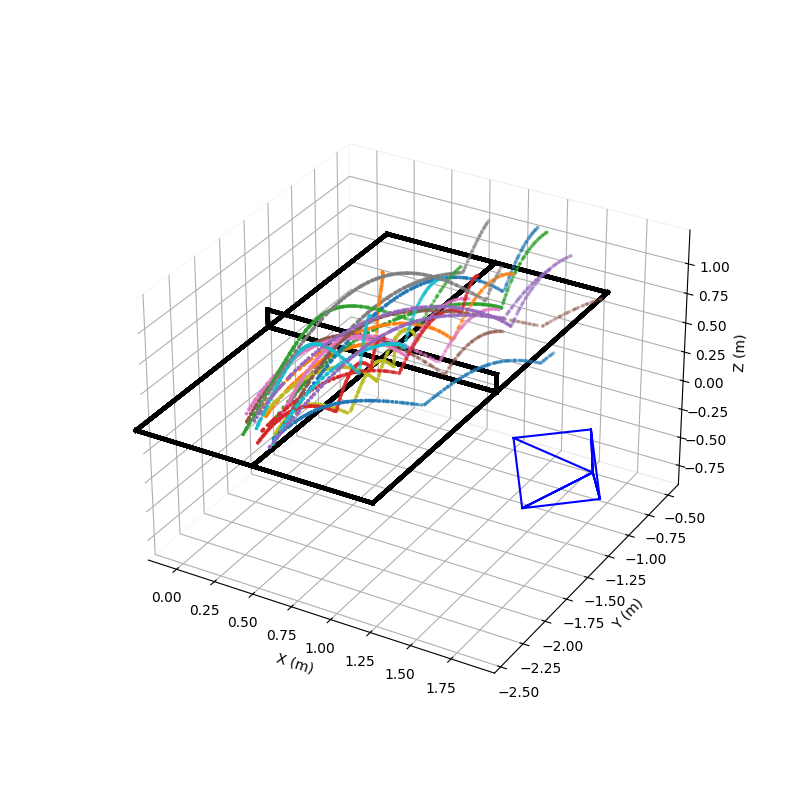

In [6]:
def load_synthetic_data(file_path):
    with open(file_path, mode='r') as f:
        reader = csv.reader(f)
        data = [row for row in reader]
    data = np.array(data, dtype=float)
    return data
def view_synthetic_data(file_path):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')

    data = load_synthetic_data(file_path)
    traj_idx_list = np.arange(int(data[-1,0]))
    traj_idx_list = np.random.choice(traj_idx_list, 200, replace=True)
    for traj_idx in traj_idx_list[:-1:10]:
        traj = data[data[:,0] == traj_idx, 2:]
        ax.scatter(traj[:,0],traj[:,1],traj[:,2],s=3, label='sim')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        draw_util.set_axes_equal(ax)
        draw_util.set_axes_pane_white(ax)
        draw_util.draw_pinpong_table_outline(ax)
    for cm in camera_param_dict.values():
        cm.draw(ax,scale=0.20)
if VIEW_SYNTHETIC_DATA:
    view_synthetic_data(file_path)

In [7]:
def get_w0_from_traj_idx(data, traj_idx):
    traj = data[data[:,0] == traj_idx, :]
    w0 = traj[0, 8:11]
    return  w0

def generate_camera_data_with_noise(csv_file_path, camera_param_dict:dict[CameraParam], dev_uv):
    data = load_synthetic_data(csv_file_path)
    with open(Path(CONFIG.dataset.folder) / CONFIG.dataset.camera_data, mode='w') as f:
        writer = csv.writer(f)
        # for data_idx, row in enumerate(data):
        for data_idx, row in tqdm(enumerate(data)):
            traj_idx = int(row[0])
            w0 = get_w0_from_traj_idx(data, traj_idx)
            t = row[1]
            xyz = row[2:5]
            camera_id = camera_ids[data_idx % len(camera_ids)]  # Select camera parameter based on traj_idx
            cm = camera_param_dict[camera_id]
            uv = cm.proj2img(xyz)
            uv = noise_uv(uv, dev_uv)
            writer.writerow([traj_idx, data_idx, t, camera_id, uv[0], uv[1],w0[0],w0[1],w0[2]])


if GENERATE_CAMERA_DATA_WITH_NOISE:
    generate_camera_data_with_noise(file_path, camera_param_dict, CONFIG.synthetic.uv_noise)

100000it [00:26, 3755.84it/s]


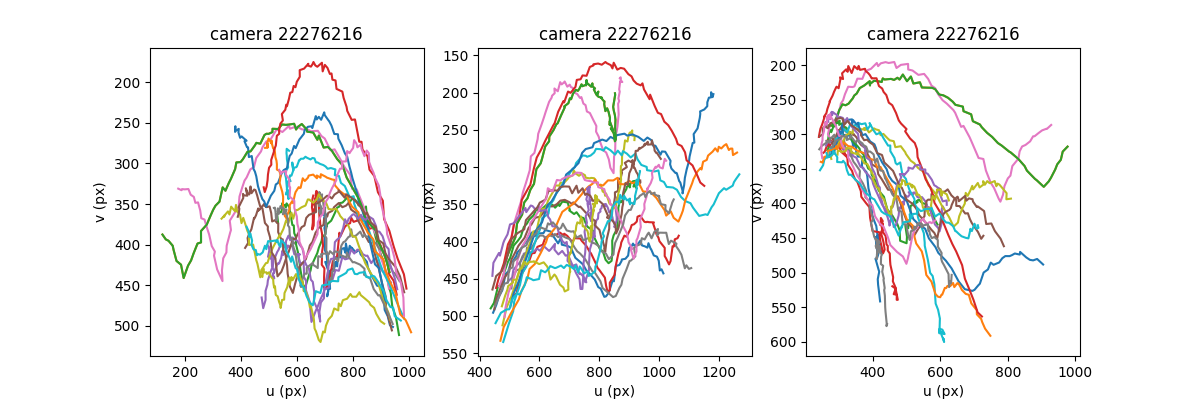

In [8]:
def view_synthetic_camera_data(csv_file_path):
    fig = plt.figure(figsize=(12,4))
    ax_dict = {cam_id: fig.add_subplot(1,3,i+1) for i, cam_id in enumerate(camera_ids)}

    data = load_synthetic_data(csv_file_path)
    traj_idx_list = np.arange(int(data[-1,0]))
    traj_idx_list = np.random.choice(traj_idx_list, 200, replace=True)
    for traj_idx in traj_idx_list[:-1:10]:
        for cam_id in camera_ids:
            ax = ax_dict[cam_id]
            uv = data[(data[:,0].astype(int) == traj_idx) & (data[:,3].astype(int) == int(cam_id)), 4:6]
            ax.plot(uv[:,0],uv[:,1],linestyle='-')
            
    for ax in ax_dict.values():
        ax.set_xlabel('u (px)')
        ax.set_ylabel('v (px)')
        ax.set_title(f'camera {cam_id}')
        ax.invert_yaxis()
        
if VIEW_SYNTHETIC_CAMERA_DATA:
    view_synthetic_camera_data(Path(CONFIG.dataset.folder) / CONFIG.dataset.camera_data)